In [1]:
import tarfile
import urllib.request
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
plt.set_cmap("gray") # Otherwise grayscale images look purple
%matplotlib inline

In [2]:
url = 'http://udon.stacken.kth.se/~ninjin/comp0090_assignment_1_data.tar.gz'
ftpstream = urllib.request.urlopen(url)
tar = tarfile.open(fileobj=ftpstream, mode="r|gz")
tar.extractall()
tar.close

<bound method TarFile.close of <tarfile.TarFile object at 0x000001CE0FA490B8>>

In [3]:
trainxs = np.load("comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((2, 1, 0))
trainys = np.load("comp0090_assignment_1_data/fashion-train-labels.npz")
devxs   = np.load("comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((2, 1, 0))
devys   = np.load("comp0090_assignment_1_data/fashion-dev-labels.npz")
testxs  = np.load("comp0090_assignment_1_data/fashion-test-imgs.npz").transpose((2, 1, 0))
testys  = np.load("comp0090_assignment_1_data/fashion-test-labels.npz")

In [4]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)
print(testxs.shape)
print(testys.shape)

(12000, 28, 28)
(12000,)
(1000, 28, 28)
(1000,)
(1000, 28, 28)
(1000,)


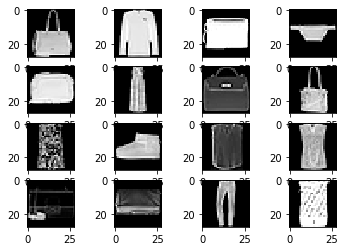

In [5]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axarr[i, j].imshow(trainxs[np.random.randint(0, len(trainxs))])

In [6]:
# reshape data to make it easier to work with
trainxs = trainxs.reshape(-1, 784)
devxs = devxs.reshape(-1, 784)
testxs = testxs.reshape(-1, 784)

In [7]:
# function to create weight and sum parameters for the algorithm
def initialise_parameters(xs):
    w = np.zeros(xs.shape[1])
    b = 0
    return w, b

In [8]:
# logistic function definition
def logistic_func(x):
    return 1/(1 + np.exp(-x))

# logistic function derivative definition
def logistic_der(x):
    return logistic_func(x) * (1 - logistic_func(x))

# target function of logistic regression 
def f(x, w, b):
    return logistic_func(np.dot(w, x) + b)

# probability threshold
def p(x, w, b):
    if f(x, w, b) >= 0.5:
        return 1
    return 0

In [9]:
# measure accuracy
def accuracy(xs, ys, w, b):
    correct = 0
    for i in range(xs.shape[0]):
        if p(xs[i], w, b) == ys[i]:
            correct += 1
    return correct/len(xs)*100    

In [10]:
# measure MSE loss
def loss_func(ys, y_predict):
    sum = 0
    n = ys.shape[0]
    for i in range(n):
        sum += (ys[i] - y_predict[i]) ** 2
    return sum / (2*n)

In [11]:
# measure MSE loss for single data points
def loss(y, y_hat):
    return ((y - y_hat) ** 2) / 2

In [12]:
# generate prediction for y on validation set
def validation_predictions(devxs, devys, w, b):
    y_predict = []
    
    for i in range(devxs.shape[0]):
        y_hat = f(devxs[i], w, b)
        y_predict.append(y_hat)
        
    return y_predict

In [73]:
# logistic regression model main function
def logistic_regression(trainxs, trainys, devxs, devys):
    w, b = initialise_parameters(trainxs)
    y_predict = []
    
    # store accuracy and loss metrics for each epoch
    accuracy_training = []
    accuracy_validation = []
    
    loss_training = []
    loss_validation = []
    
    mse_train_list = []
    mse_val_list = []
    
    # store old accuracy and consecutive epochs count to detect convergence
    loss_old = loss_func(devys, validation_predictions(devxs, devys, w, b))
    row_epoch = 0
    
    # store number of epochs to have a nice graph
    epoch = 0
    learning_rate = 0.1
    
    while True:
        print('Epoch', epoch)
        trainxs, trainys = shuffle(trainxs, trainys)
        grad_w, grad_b = initialise_parameters(trainxs)
        y_predict = []

        for i in range(trainxs.shape[0]):
            y_hat = f(trainxs[i], w, b)
            y_predict.append(y_hat)
            grad_w += trainxs[i] * (y_hat - trainys[i]) * (1 - y_hat) * y_hat 
            grad_b += (y_hat - trainys[i]) * (1 - y_hat) * y_hat 

        grad_w /= trainxs.shape[0]
        grad_b /= trainxs.shape[0]
        w -= learning_rate * grad_w
        b -= learning_rate * grad_b

        accuracy_train = accuracy(trainxs, trainys, w, b)
        accuracy_training.append(accuracy_train)
        print('Training set accuracy:', accuracy(trainxs, trainys, w, b))
        accuracy_dev = accuracy(devxs, devys, w, b)
        accuracy_validation.append(accuracy_dev)
        print('Validation set accuracy:', accuracy_dev)
        
        loss_train = loss_func(trainys, y_predict)
        loss_training.append(loss_train)
        print('Training set loss:', loss_train)
        loss_dev = loss_func(devys, validation_predictions(devxs, devys, w, b))
        loss_validation.append(loss_dev)
        print('Validation set loss:', loss_dev)
        
        mse_training = mean_squared_error(trainys, y_predict)/2
        mse_train_list.append(mse_training)
        mse_validation = mean_squared_error(devys, validation_predictions(devxs, devys, w, b))/2
        mse_val_list.append(mse_validation)
        
        # check if converged
        if np.abs(loss_dev - loss_old) < 0.00001:
            row_epoch += 1
            if row_epoch == 5:
                break
        else:
            row_epoch = 0
            
        loss_old = loss_dev
        epoch += 1
    
    return epoch, accuracy_training, accuracy_validation, loss_training, loss_validation, mse_train_list, mse_val_list

In [74]:
epoch, accuracy_training, accuracy_validation, loss_training, loss_validation, mse_train_list, mse_val_list = logistic_regression(trainxs, trainys, devxs, devys)

Epoch 0
Training set accuracy: 55.95833333333333
Validation set accuracy: 56.89999999999999
Training set loss: 0.125
Validation set loss: 0.11715526461237143
Epoch 1
Training set accuracy: 66.4
Validation set accuracy: 68.4
Training set loss: 0.11758031575658451
Validation set loss: 0.11166747791745216
Epoch 2
Training set accuracy: 71.98333333333333
Validation set accuracy: 71.89999999999999
Training set loss: 0.11214173444297762
Validation set loss: 0.10685128822965709
Epoch 3
Training set accuracy: 76.40833333333333
Validation set accuracy: 76.2
Training set loss: 0.10732754581143043
Validation set loss: 0.10257258197945791
Epoch 4
Training set accuracy: 78.34166666666667
Validation set accuracy: 78.8
Training set loss: 0.10306007592268604
Validation set loss: 0.09876912731742027
Epoch 5
Training set accuracy: 79.48333333333333
Validation set accuracy: 80.2
Training set loss: 0.09927988984547208
Validation set loss: 0.09538216917298473
Epoch 6
Training set accuracy: 80.15
Validation

Training set accuracy: 90.675
Validation set accuracy: 92.0
Training set loss: 0.052171412920391284
Validation set loss: 0.05001261861127951
Epoch 53
Training set accuracy: 90.85
Validation set accuracy: 92.0
Training set loss: 0.05180580256160924
Validation set loss: 0.049645398511079866
Epoch 54
Training set accuracy: 91.00833333333334
Validation set accuracy: 92.0
Training set loss: 0.051448170553954634
Validation set loss: 0.04928625843969878
Epoch 55
Training set accuracy: 91.14999999999999
Validation set accuracy: 92.10000000000001
Training set loss: 0.051098247888015806
Validation set loss: 0.048934927717816434
Epoch 56
Training set accuracy: 91.28333333333333
Validation set accuracy: 92.2
Training set loss: 0.05075577876979375
Validation set loss: 0.048591148568652404
Epoch 57
Training set accuracy: 91.38333333333334
Validation set accuracy: 92.4
Training set loss: 0.05042051968024133
Validation set loss: 0.048254675243929006
Epoch 58
Training set accuracy: 91.50833333333334
Va

Training set accuracy: 94.075
Validation set accuracy: 94.8
Training set loss: 0.03996462321925828
Validation set loss: 0.037806457412838695
Epoch 105
Training set accuracy: 94.08333333333333
Validation set accuracy: 94.8
Training set loss: 0.03981615184470496
Validation set loss: 0.03765885975946416
Epoch 106
Training set accuracy: 94.075
Validation set accuracy: 94.89999999999999
Training set loss: 0.039669709428811255
Validation set loss: 0.037513303571831864
Epoch 107
Training set accuracy: 94.09166666666667
Validation set accuracy: 95.0
Training set loss: 0.039525253618471756
Validation set loss: 0.03736974591963002
Epoch 108
Training set accuracy: 94.1
Validation set accuracy: 95.0
Training set loss: 0.03938274322056393
Validation set loss: 0.037228145055452765
Epoch 109
Training set accuracy: 94.10833333333333
Validation set accuracy: 95.0
Training set loss: 0.03924213816306279
Validation set loss: 0.03708846037490156
Epoch 110
Training set accuracy: 94.125
Validation set accura

Training set accuracy: 94.75
Validation set accuracy: 95.5
Training set loss: 0.03423554321476818
Validation set loss: 0.0321309396271051
Epoch 157
Training set accuracy: 94.75
Validation set accuracy: 95.5
Training set loss: 0.03415446074691877
Validation set loss: 0.03205093675905566
Epoch 158
Training set accuracy: 94.76666666666667
Validation set accuracy: 95.5
Training set loss: 0.03407417098518436
Validation set loss: 0.03197172572967112
Epoch 159
Training set accuracy: 94.76666666666667
Validation set accuracy: 95.5
Training set loss: 0.03399466176664029
Validation set loss: 0.03189329428648644
Epoch 160
Training set accuracy: 94.79166666666666
Validation set accuracy: 95.5
Training set loss: 0.03391592117757664
Validation set loss: 0.03181563042911234
Epoch 161
Training set accuracy: 94.8
Validation set accuracy: 95.5
Training set loss: 0.033837937547178065
Validation set loss: 0.031738722402820586
Epoch 162
Training set accuracy: 94.8
Validation set accuracy: 95.5
Training set

Training set accuracy: 95.05
Validation set accuracy: 95.7
Training set loss: 0.030855768337270936
Validation set loss: 0.028804761468774694
Epoch 209
Training set accuracy: 95.05
Validation set accuracy: 95.7
Training set loss: 0.03080396213461295
Validation set loss: 0.028753915716177966
Epoch 210
Training set accuracy: 95.05833333333334
Validation set accuracy: 95.7
Training set loss: 0.030752545305716965
Validation set loss: 0.028703456209464382
Epoch 211
Training set accuracy: 95.05
Validation set accuracy: 95.7
Training set loss: 0.030701513177534036
Validation set loss: 0.028653378261063085
Epoch 212
Training set accuracy: 95.05833333333334
Validation set accuracy: 95.7
Training set loss: 0.03065086115267177
Validation set loss: 0.028603677259680882
Epoch 213
Training set accuracy: 95.06666666666666
Validation set accuracy: 95.7
Training set loss: 0.03060058470786339
Validation set loss: 0.02855434866875696
Epoch 214
Training set accuracy: 95.075
Validation set accuracy: 95.7
Tr

Training set accuracy: 95.24166666666667
Validation set accuracy: 95.8
Training set loss: 0.028628663924074278
Validation set loss: 0.0266224738754637
Epoch 260
Training set accuracy: 95.24166666666667
Validation set accuracy: 95.8
Training set loss: 0.028592022242880693
Validation set loss: 0.026586624385119925
Epoch 261
Training set accuracy: 95.24166666666667
Validation set accuracy: 95.8
Training set loss: 0.028555603497630314
Validation set loss: 0.026550994506252572
Epoch 262
Training set accuracy: 95.24166666666667
Validation set accuracy: 95.8
Training set loss: 0.02851940549455844
Validation set loss: 0.02651558204848792
Epoch 263
Training set accuracy: 95.24166666666667
Validation set accuracy: 95.8
Training set loss: 0.02848342606921162
Validation set loss: 0.02648038485093261
Epoch 264
Training set accuracy: 95.25
Validation set accuracy: 95.8
Training set loss: 0.02844766308595674
Validation set loss: 0.02644540078167853
Epoch 265
Training set accuracy: 95.25
Validation se

Training set accuracy: 95.38333333333333
Validation set accuracy: 96.0
Training set loss: 0.02697726000788124
Validation set loss: 0.025007966779851343
Epoch 312
Training set accuracy: 95.39166666666667
Validation set accuracy: 96.0
Training set loss: 0.026949838502405767
Validation set loss: 0.0249811718645893
Epoch 313
Training set accuracy: 95.39166666666667
Validation set accuracy: 96.1
Training set loss: 0.026922556043443544
Validation set loss: 0.024954512997538918
Epoch 314
Training set accuracy: 95.39999999999999
Validation set accuracy: 96.1
Training set loss: 0.02689541147853857
Validation set loss: 0.024927989034343415
Epoch 315
Training set accuracy: 95.39999999999999
Validation set accuracy: 96.1
Training set loss: 0.02686840366827451
Validation set loss: 0.024901598843719668
Epoch 316
Training set accuracy: 95.39999999999999
Validation set accuracy: 96.1
Training set loss: 0.02684153148608716
Validation set loss: 0.024875341307271343
Epoch 317
Training set accuracy: 95.39

Training set accuracy: 95.45833333333333
Validation set accuracy: 96.0
Training set loss: 0.025734920600273763
Validation set loss: 0.023793935315816018
Epoch 363
Training set accuracy: 95.45
Validation set accuracy: 96.0
Training set loss: 0.025713352689466017
Validation set loss: 0.023772851856317424
Epoch 364
Training set accuracy: 95.45
Validation set accuracy: 96.0
Training set loss: 0.025691878475282898
Validation set loss: 0.023751859530595235
Epoch 365
Training set accuracy: 95.45833333333333
Validation set accuracy: 96.0
Training set loss: 0.02567049728667429
Validation set loss: 0.023730957676233077
Epoch 366
Training set accuracy: 95.46666666666667
Validation set accuracy: 96.0
Training set loss: 0.025649208459179746
Validation set loss: 0.02371014563739738
Epoch 367
Training set accuracy: 95.46666666666667
Validation set accuracy: 96.0
Training set loss: 0.02562801133484824
Validation set loss: 0.023689422764755563
Epoch 368
Training set accuracy: 95.46666666666667
Validati

Training set accuracy: 95.55833333333334
Validation set accuracy: 95.89999999999999
Training set loss: 0.024777172725674628
Validation set loss: 0.02285706850167339
Epoch 412
Training set accuracy: 95.56666666666666
Validation set accuracy: 95.89999999999999
Training set loss: 0.02475951296731731
Validation set loss: 0.02283977756172446
Epoch 413
Training set accuracy: 95.56666666666666
Validation set accuracy: 95.89999999999999
Training set loss: 0.02474192049239959
Validation set loss: 0.022822551750831713
Epoch 414
Training set accuracy: 95.56666666666666
Validation set accuracy: 95.89999999999999
Training set loss: 0.024724394875391534
Validation set loss: 0.022805390651387522
Epoch 415
Training set accuracy: 95.56666666666666
Validation set accuracy: 95.89999999999999
Training set loss: 0.02470693569446691
Validation set loss: 0.022788293849469135
Epoch 416
Training set accuracy: 95.56666666666666
Validation set accuracy: 95.89999999999999
Training set loss: 0.02468954253146388
Va

Training set accuracy: 95.68333333333334
Validation set accuracy: 95.89999999999999
Training set loss: 0.02398384396489441
Validation set loss: 0.022079419929977008
Epoch 461
Training set accuracy: 95.68333333333334
Validation set accuracy: 95.89999999999999
Training set loss: 0.023969041209259554
Validation set loss: 0.022064889365722453
Epoch 462
Training set accuracy: 95.68333333333334
Validation set accuracy: 95.89999999999999
Training set loss: 0.02395428859175549
Validation set loss: 0.022050407148920335
Epoch 463
Training set accuracy: 95.68333333333334
Validation set accuracy: 95.89999999999999
Training set loss: 0.023939585828854536
Validation set loss: 0.02203597300292431
Epoch 464
Training set accuracy: 95.68333333333334
Validation set accuracy: 95.89999999999999
Training set loss: 0.02392493263924222
Validation set loss: 0.022021586653280564
Epoch 465
Training set accuracy: 95.68333333333334
Validation set accuracy: 95.89999999999999
Training set loss: 0.023910328743797934


Training set accuracy: 95.75
Validation set accuracy: 95.89999999999999
Training set loss: 0.023325359954688797
Validation set loss: 0.02143209599885761
Epoch 509
Training set accuracy: 95.75833333333334
Validation set accuracy: 95.89999999999999
Training set loss: 0.02331267845599644
Validation set loss: 0.021419608124684294
Epoch 510
Training set accuracy: 95.75833333333334
Validation set accuracy: 95.89999999999999
Training set loss: 0.023300035650396074
Validation set loss: 0.021407157458767274
Epoch 511
Training set accuracy: 95.75833333333334
Validation set accuracy: 95.89999999999999
Training set loss: 0.023287431339841888
Validation set loss: 0.021394743808911428
Epoch 512
Training set accuracy: 95.76666666666667
Validation set accuracy: 95.89999999999999
Training set loss: 0.023274865327692747
Validation set loss: 0.021382366984305318
Epoch 513
Training set accuracy: 95.76666666666667
Validation set accuracy: 95.89999999999999
Training set loss: 0.02326233741869892
Validation 

Training set accuracy: 95.81666666666668
Validation set accuracy: 95.89999999999999
Training set loss: 0.02275712160900449
Validation set loss: 0.02087157398729094
Epoch 557
Training set accuracy: 95.81666666666668
Validation set accuracy: 95.89999999999999
Training set loss: 0.022746096028881942
Validation set loss: 0.020860677010963745
Epoch 558
Training set accuracy: 95.81666666666668
Validation set accuracy: 95.89999999999999
Training set loss: 0.02273510102516345
Validation set loss: 0.02084980938456806
Epoch 559
Training set accuracy: 95.81666666666668
Validation set accuracy: 95.89999999999999
Training set loss: 0.02272413645502881
Validation set loss: 0.020838970970198805
Epoch 560
Training set accuracy: 95.81666666666668
Validation set accuracy: 95.89999999999999
Training set loss: 0.022713202176584277
Validation set loss: 0.020828161630859196
Epoch 561
Training set accuracy: 95.81666666666668
Validation set accuracy: 95.89999999999999
Training set loss: 0.022702298048855908
V

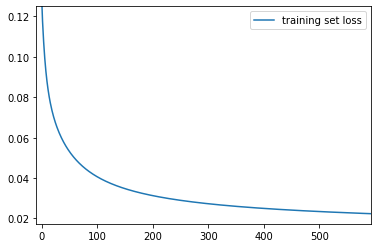

In [82]:
plt.axis([-10, epoch, min(loss_training) - 0.005, max(loss_training)])
plt.plot(loss_training, label='training set loss')
#plt.plot(loss_validation, label='validation set loss', color='r')
plt.legend(loc='upper right')

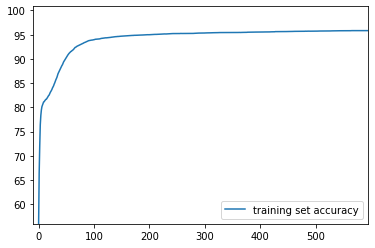

In [76]:
plt.axis([-10, epoch, min(accuracy_training), max(accuracy_training) + 5])
plt.plot(accuracy_training, label='training set accuracy')
#plt.plot(accuracy_validation, label='validation set accuracy', color='r')
plt.legend(loc='lower right')

In [77]:
ind = accuracy_validation.index(max(accuracy_validation))
print("Best epoch =", ind)
print("Accuracy on training set =", accuracy_training[ind])
print("Accuracy on validation set =", accuracy_validation[ind])

Best epoch = 313
Accuracy on training set = 95.39166666666667
Accuracy on validation set = 96.1


In [15]:
print("mse training loss: ", mse_train_list)
print("our training loss: ", loss_training)

mse training loss:  [0.125, 0.11758031575658488, 0.11214173444297776, 0.10732754581143035, 0.1030600759226863, 0.09927988984547187, 0.09592490463979349, 0.09293625800817144, 0.09026113728526274, 0.08785367163428165, 0.08567478400541657, 0.08369155407878745, 0.08187640814059816, 0.08020630157100056, 0.07866197101512377, 0.0772272845873897, 0.07588869358033219, 0.07463477770364599, 0.07345587160436155, 0.07234375973883139, 0.0712914276258896, 0.07029285908435216, 0.06934287074019445, 0.0684369766498912, 0.06757127724051365, 0.0667423678985644, 0.06594726346415969, 0.06518333563280893, 0.06444826086361156, 0.06373997686792161, 0.0630566461303648, 0.06239662521441951, 0.06175843884370647, 0.061140757940567274, 0.06054238095565273, 0.05996221794413642, 0.05939927694213525, 0.05885265227592158, 0.058321514500441964, 0.05780510171557862, 0.05730271205090916, 0.05681369714433806, 0.056337456468393915, 0.055873432381400114, 0.055421105800084, 0.05497999240624542, 0.05454963931346797, 0.05412962

In [16]:
print("mse val loss: ", mse_val_list)
print("pour val loss: ", loss_validation)

mse val loss:  [0.11715526461237132, 0.11166747791745217, 0.10685128822965703, 0.10257258197945782, 0.09876912731742038, 0.09538216917298459, 0.09235575045133314, 0.08963916553053879, 0.08718804628863795, 0.08496438531543044, 0.08293602219731278, 0.08107592122327409, 0.0793614164475059, 0.07777350848691052, 0.07629624660415588, 0.07491620324667636, 0.07362203569088274, 0.07240412439839543, 0.07125427646638352, 0.0701654831283722, 0.06913172156509377, 0.06814779277680115, 0.0672091886956367, 0.06631198297624831, 0.06545274096736219, 0.06462844524415982, 0.06383643379308493, 0.06307434851302389, 0.06234009215458694, 0.061631792184448975, 0.06094777035288512, 0.0602865169749052, 0.059646669120946266, 0.05902699206163895, 0.05842636343041237, 0.0578437596637106, 0.057278244356139284, 0.056728958230703966, 0.05619511047540724, 0.05567597123917611, 0.055170865114243677, 0.05467916546017451, 0.0542002894478653, 0.05373369372099861, 0.053278870588319906, 0.05283534467334194, 0.0524026699591323

In [20]:
def flatten(w, b):
    toflatten = (w, [b])
    vec = np.zeros(sum(len(x) for x in toflatten))
    offset = 0
    for parameter in toflatten:
        vec[offset:offset + len(parameter)] = parameter
        offset += len(parameter)
    return vec

In [21]:
def unflatten(w, b, vec):
    tounflatten = (w, [b])
    offset = 0
    for parameter in tounflatten:
        parameter[:] = vec[offset:offset + len(parameter)]
        offset += len(parameter)
    return tounflatten

In [22]:
def fdfprime(w, b, x, y):
    epsilon  = 0.000001
    grad_w = np.zeros_like(w)
    grad_b = 0.0
    vecm     = flatten(w, b)
    vecgradm = flatten(grad_w, grad_b)
    
    for i in range(len(vecm)):
        wi           = vecm[i]

        vecm[i]     += epsilon/2       
        w_j, b_j     = unflatten(grad_w, grad_b, vecm)
        r            = loss(y, f(x, w_j, b_j))
        vecm[i]      = wi
        vecm[i]     -= epsilon/2
        w_j, b_j     = unflatten(grad_w, grad_b, vecm)
        l            = loss(y, f(x, w_j, b_j))
        vecgradm[i]  = (r - l)/epsilon

        vecm[i]      = wi

    return unflatten(grad_w, grad_b, vecgradm)


In [23]:
def fprime(n, x, y, w, b):
    grad_w = np.zeros(n)
    grad_b = 0.0
    
    #Forward pass
    z = np.dot(w, x) + b
    y_hat = logistic_func(z)
    
    #Backward pass
    grad_z = (y_hat - y) * logistic_der(z)
    grad_w += x * (y_hat - y) * (1 - y_hat) * y_hat 
    grad_b += (y_hat - y) * (1 - y_hat) * y_hat
    
    return (grad_w, [grad_b])

In [24]:
x = trainxs[0]
y = trainys[0]
w = np.random.random(784) / 100
grad_w, grad_b = fprime(trainxs.shape[1], x, y, w, 0.0)
fd_grad_w, fd_grad_b = fdfprime(w, 0.0, x, y)

In [25]:
fd_b = np.subtract(fd_grad_b,grad_b)
fd_w = np.subtract(fd_grad_w,grad_w)
max_fd = fd_w.max()
print(fd_b)
print(fd_w)
print("Max difference for w:", max_fd)

[-3.59789976e-11]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.59590674e-11  3.97840649e-11
 -1.33445893e-11 -3.15701632e-11 -4.45147114e-11  4.06184669e-11
 -3.02197156e-11 -3.20861948e-11 -3.65328046e-11  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -7.31815997e-11 -3.53031215e-11 -9.42288053e-11
 -8.89477936e-11  4.88099838e-12  1.73095149e-11 -9.42288053e-11
 -7.65192631e-11  1.91759802e-11  1.24917271e-10  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.000